# FOTS: Fast Oriented Text Spotting with a Unified Network

Text detection and recognition (also known as Text Spotting) from an image is a very useful and challenging problem that deep learning researchers have been working on since many years because of its practical applications in fields like document scanning, robot navigation and image retrieval, etc. Almost all the methods consisted of two separate stages so far: 1) Text detection 2) Text recognition. Text detection just finds out where the text is located in the given image and on these results, text recognition actually recognizes the characters from the text. Because of these two stages, two separate models were required to be trained and hence prediction time was a bit higher. Because of higher test time, the models were not suitable for real time applications. Contrary to this, FOTS solves this two stage problem using a unified end to end trainable model/network by detecting and recognizing text simultaneously. It uses shared convolutional features between text detection and recognition tasks which learns more generic features and improves the test time such that it can be useful in real time applications such as OCR from video streams at higher FPS. FOTS also improves text detection on scenes having aligned/rotated texts because of its special component named “RoIRotate” (Region of Interest Rotate), which rotates the aligned text by keeping aspect ratio the same and then applies text recognition.

### Why This problem Needs to be Solved? 

Reading text in natural images has attracted increasing attention in the computer vision community .And since this problem is combination of Computer Vision and NLP it has numerous practical applications in document analysis, scene understanding, robot navigation, image retrieval ,self driving cars,etc . It’s also one of the most challenging tasks because of the of the different fonts, sizes/scales and alignment of the text in real life images.

### How Machine Learning Is helping in Solving the Problem?

According to the research paper FOTS we can consider this problem as two sub problems first as text detection(in which we are detecting where actually the text is in the real world image with the help of generated bounding boxes around the text) and second as text recognition(which recognizes actually what is the text in the generated bounding boxes in image).

We are going to design a fast oriented text spotting unified network with the help of deep learning techiques like CNNs,ResNet,LSTMs,sequential decoder,etc which is solving these two subproblems at the same time.We are going to build a trainable model end to end which can do detection and recognition at the same time with the minimum loss.

### Losses Used for the Problem

##### Text Detection Has two Losses : Dice Loss and IOu Loss    

#### Dice Loss

Understanding Dice Loss for Crisp BoundaryDetection.Why dice loss is a far better alternative tha Cross Entropy Loss? When using cross entropy loss, the statistical distributions of labels play a big role in training accuracy. The more unbalanced the label distributions are, the more difficult the training will be. Although weighted cross entropy loss can alleviate the difficulty, the improvement is not significant nor the intrinsic issue of cross entropy loss is solved. In cross entropy loss, the loss is calculated as the average of per-pixel loss, and the per-pixel loss is calculated discreetly, without knowing whether its adjacent pixels are boundaries or not. As a result, cross entropy loss only considers loss in a micro sense rather than considering it globally, which is not enough for image level prediction. Now Dice Loss considers if the pixel is boundary or not.

$D = \frac{2\Sigma_{i}p_{i}g_{i}}{\Sigma_{i}p_{i}^2 + \Sigma_{i}g_{i}^2}$

Here, pi represent predicted boundary box and gi is ground truth.The value
of pi and gi will either be 1 or 0 , which means whether pixel is boundary or
not.So denominator is total boundary pixel of of both predicted and ground
truth and numerator is the sum of correctly predicted pixels because it only
increase when pi and gi matches to 1.

#### IOU Loss

In object detection task, we try to guide the computer to predict the objects and their location in a given image data. accomplish this, we try to formulate a mechanism to mimic the behavior of “localizing” an object by enclosing them with a “rectangle” notation which is usually called as a bounding box.These bounding boxes, usually annotated as 4 points of value represents either specific corner/center points of the coordinates of the bounding box or its width/height. The usual format of the annotation is either (left, top, right, bottom), (left, top, width, height), or (center_x, center_y, width, height). Thus, the deep learning for object detection task is designed specifically to predict values related to those points by regressing them for the localization part.Earlier Ln-norm based loss was used as cost function.Thus, Rezatofighi et al. 2019 proposed the first approach towards IoU-based bounding box regression loss. Theformula was:

$L_{IoU} = 1 - \frac{B \cap B_{gt}}{B \cup B_{gt}}$

#### Text Recogntion has Loss - CTC Loss

##### CTC Loss

CTC Loss: CTC stands for connectionist temporal classification . how does the model align between the input and output to locate each character in the image and turn them into text? That is where CTC comes into play. The CTC cost function allows the RNN to generate output like: CTC introduced the blank token in between characters to separate them.it does so to separate individual characters so that repeated characters which do not have blank token will collapse into one character. In order to compute the CTC loss, At each time stamp, the network outputs the probability distributions over possible labels values. If we select randomly any label independently, what is the possibility that this will give an output sequence that collapses into ground truth. The CTC loss is the negative logarithm of this probability

### Dataset Information

To train the end to end FOTS model, as suggested by the original paper, the following datasets should be used:
    
SynthText Dataset: which is a synthetically generated dataset, in which word instances are placed in natural scene images, while taking into account the
scene layouts. This is a very large dataset which contains 800K images with different texts.

ICDAR-2015 Dataset: This is a real world dataset having images from wearable cameras. This dataset is comparatively very small (only 1000
training images) as compared to SynthText dataset.
    
As the SynthText dataset is large enough, the paper suggests to train the entire model on it and then to adapt the real world images, the model can
be fine tuned on the ICDAR-2015 dataset.


In [ ]:
# Importing the libraries
import os
import re
import cv2
import scipy.io
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patches as patches
from tqdm import tqdm

In [ ]:
#Plotting the 2 X 2 images grid
def show_images(images):
    f, ax = plt.subplots(2, 2, figsize=(20, 15))
    ax = ax.flatten()

    for index in range(4):
        # Read the image from given path and plot
        image = cv2.imread(images[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10,10))
        ax[index].imshow(image)

In [24]:
# https://github.com/sugam95/FOTS/blob/main/fots_eda.ipynb
#Plotiing the 2 X 2 images grid
def display_Images(images):
    _, axis = plt.subplots(2, 2, figsize=(15, 15))
    axis = axis.flatten()

    for index in range(4):
        # Read the image from given path and plot
        image = cv2.imread(images[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10,10))
        axis[index].imshow(image)

In [ ]:
def image_describe(folder):
    files=[]
    for root,dirs,file in tqdm(os.walk(folder,topdown=True)):
        for fil in file:
            files.append(root+os.sep+fil)
    return files 

In [48]:
# Function for generating bounding boxes on the image of text
def show_bboxes(images, bbox, color='red'):

    _,axis = plt.subplots(2,2,figsize=(15, 15))
    axis = axis.flatten()

    for i in range(4):
        image = cv2.imread(images[i], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        for j in range(bbox[i].shape[-1]):
            
            vertices = [
                (bbox[i][0][0][j], bbox[i][1][0][j]),
                (bbox[i][0][1][j], bbox[i][1][1][j]),
                (bbox[i][0][2][j], bbox[i][1][2][j]),
                (bbox[i][0][3][j], bbox[i][1][3][j])]

            bboxes = patches.Polygon(
                vertices,
                linewidth=2,
                edgecolor=color,
                facecolor='none',
            )
            axis[i].add_patch(bboxes)

        axis[i].imshow(image)

In [ ]:
def distance_Measure(a, b):
    a, b = np.array(a), np.array(b)
    return np.sqrt(np.sum((a-b)**2))

In [ ]:
# https://github.com/sugam95/FOTS/blob/main/fots_eda.ipynb
# Adding ground truths to dataframe
def extract_gt(gt_path):
    """Extract ground truth coordinates from given text file."""
    # Reference: https://stackoverflow.com/a/49150749/5353128
    with open(gt_path, 'r', encoding='utf-8-sig') as f:
        strings = f.read().split('\n')
        strings = [line for line in strings if line]
        return np.array(list(map(lambda str: str.split(',')[:-1], strings)), dtype='object')

def extract_txt(gt_path):
    """Extract ground truth text/transcript from given text file."""
    with open(gt_path, 'r', encoding='utf-8-sig') as f:
        strings = f.read().split('\n')
        strings = [line for line in strings if line]
        return np.array(list(map(lambda str: str.split(',')[-1], strings)), dtype='object')

In [ ]:
# https://github.com/sugam95/FOTS/blob/main/fots_eda.ipynb
def plot_bb_icdar(images, bboxes ,titles , color='red'):
    """
    Plots bounding boxes over given image.
    """
    _, axis = plt.subplots(2, 2, figsize=(16, 10))
    axis = axis.flatten()

    for index in range(4):
        # Read the image from given path and plot
        image = cv2.imread(images[index], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Reference: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.Polygon.html
        for bbox_index in range(bboxes[index].shape[0]):
            # Define rectangle vertices
            vertices = [
                (bboxes[index][bbox_index][0], bboxes[index][bbox_index][1]),
                (bboxes[index][bbox_index][2], bboxes[index][bbox_index][3]),
                (bboxes[index][bbox_index][4], bboxes[index][bbox_index][5]),
                (bboxes[index][bbox_index][6], bboxes[index][bbox_index][7]),
            ]
            if list(map(str.strip, titles[index]))[bbox_index] != '###':
                # Draw the affine rectangle (polygon)
                bbox = patches.Polygon(
                    vertices,
                    linewidth=2,
                    edgecolor=color,
                    facecolor='none',
                )
                axis[index].add_patch(bbox)
        ax[index].title.set_text(", ".join([t for t in list(map(str.strip, titles[index])) if t!='###']))
        ax[index].imshow(image)

In [ ]:
#Getting all directories of whole images in a list
total_images=image_describe('synthtext')

201it [00:06, 30.88it/s]


In [ ]:
len(total_images)

858771

We are having total 858771 images in our SynthText data. As this data set is too large we will consider random sample data of this dataset for EDA

In [3]:
# As the data is is very large we will do doing EDA of some random sample data 
!unzip -qq SynthText.zip "SynthText/gt.mat" -d "."
!unzip -qq SynthText.zip "SynthText/27/*" -d "."
!unzip -qq SynthText.zip "SynthText/37/*" -d "."
!unzip -qq SynthText.zip "SynthText/47/*" -d "."
!unzip -qq SynthText.zip "SynthText/57/*" -d "."
!unzip -qq SynthText.zip "SynthText/137/*" -d "."
!unzip -qq SynthText.zip "SynthText/157/*" -d "."
!unzip -qq SynthText.zip "SynthText/187/*" -d "."
!unzip -qq SynthText.zip "SynthText/197/*" -d "."

In [26]:
#Getting all directories of sample images in a list
images=image_describe('SynthText')

In [27]:
len(images)

34357

We are having 34356 images on which we will perform EDA for images

# EDA on images

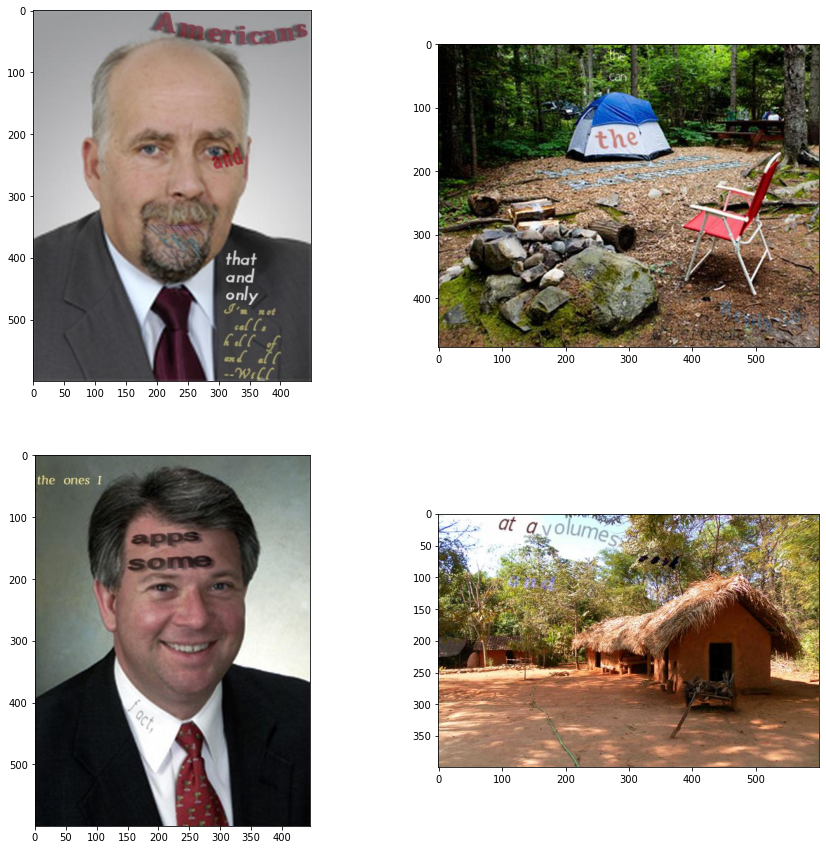

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [28]:
#plotting some random images
import random
arbitrary_Images = random.sample(images,16)
display_Images(arbitrary_Images[:4])

In [32]:
#Getting width , height and size in bytes of images
width=[]
height=[]
size=[]
images1=images[1:]
for img in tqdm(images1):   
    image = cv2.imread(img,cv2.COLOR_BGR2RGB)
    size.append(int(os.path.getsize(img)/1024))
    w, h,_=image.shape
    width.append(w)
    height.append(h)
    

100%|██████████| 34356/34356 [02:18<00:00, 247.37it/s]


In [45]:
#Converting image data to csv file
lst=[width,height,size]
img_data = pd.DataFrame(lst, index=['width', 'height','size']).T
img_data.to_csv('img_data.csv')

In [ ]:
img_data.shape

(34356, 3)

## Let's start with width of image

In [ ]:
img_data['width'].describe()

count    34356.000000
mean       438.565811
std         95.010025
min        125.000000
25%        388.000000
50%        406.000000
75%        469.000000
max        600.000000
Name: width, dtype: float64

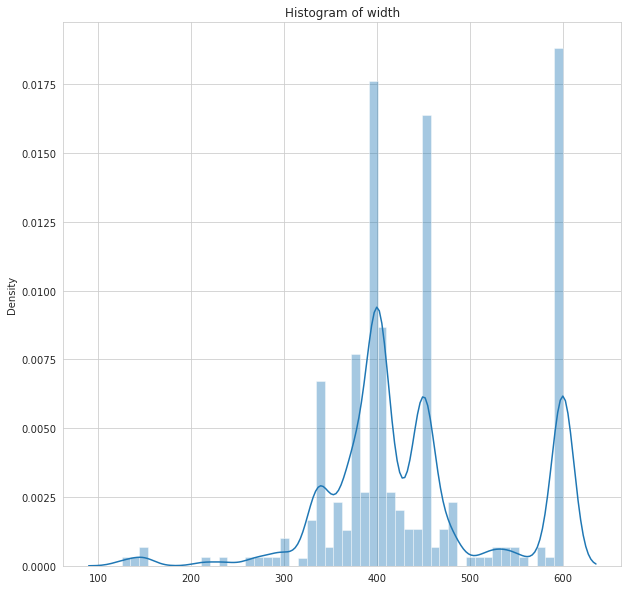

In [ ]:
#Probability Density Function for image width
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
sns.distplot(img_data['width'].values)
plt.title("Histogram of width")
plt.ylabel("Density")
plt.show()

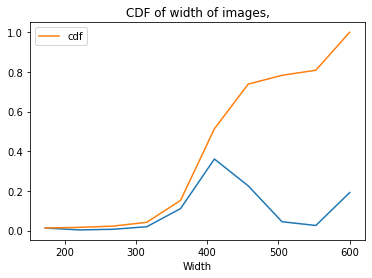

In [42]:
counts,bin_edges=np.histogram(img_data['width'],bins=10,density=True)
pdf = counts/sum(counts)
cdf=np.cumsum(pdf)
plot,=plt.plot(bin_edges[1:],pdf)
plot1,=plt.plot(bin_edges[1:],cdf)
plt.xlabel('Width')
plt.title("CDF of width of images,")
plt.legend([plot1],['cdf'])
plt.show()

Observation:
1. Most of the images are having width between 300 and 500.
2. There are few images who are having width of 600 or more.
3. There are around less than 20 percentage images whose width is less than 315.

# Now Height feature

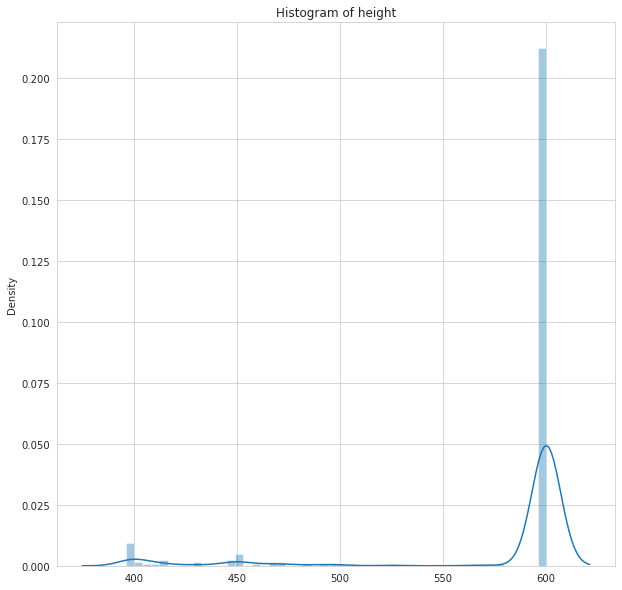

In [ ]:
#Probability Density Function for image height
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
sns.distplot(img_data['height'].values)
plt.title("Histogram of height")
plt.ylabel("Density")
plt.show()

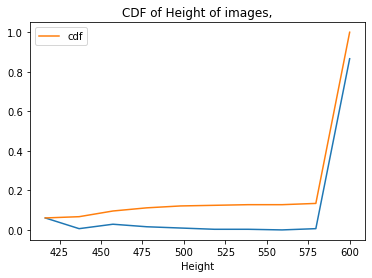

In [41]:
counts,bin_edges=np.histogram(img_data['height'],bins=10,density=True)
pdf = counts/sum(counts)
cdf=np.cumsum(pdf)
plot,=plt.plot(bin_edges[1:],pdf)
plot1,=plt.plot(bin_edges[1:],cdf)
plt.xlabel('Height')
plt.title("CDF of Height of images,")
plt.legend([plot1],['cdf'])
plt.show()

Observation:
1. Most of the images are having height of 600 or more. 
2. There are few images who are having height of less than 400. 

# Now Size Feature:

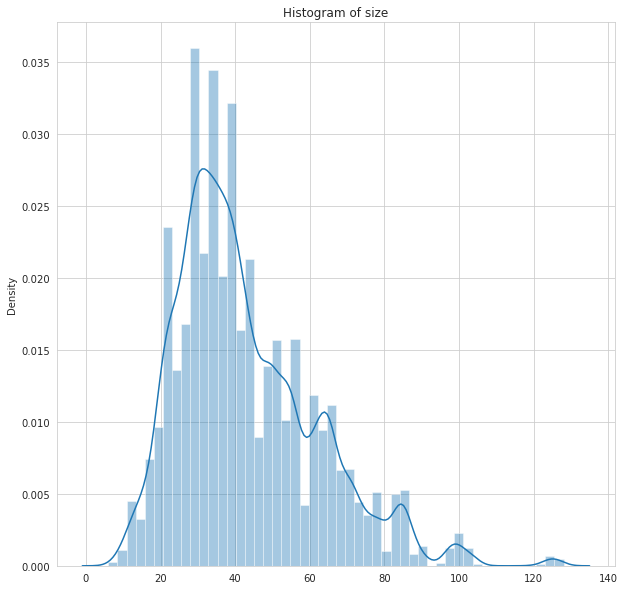

In [ ]:
#Probability Density Function for image size
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
sns.distplot(img_data['size'].values)
plt.title("Histogram of size")
plt.ylabel("Density")
plt.show()

In [43]:
counts,bin_edges=np.histogram(img_data['size'],bins=10,density=True)
pdf = counts/sum(counts)
cdf=np.cumsum(pdf)
plot,=plt.plot(bin_edges[1:],pdf)
plot1,=plt.plot(bin_edges[1:],cdf)
plt.xlabel('Size')
plt.title("CDF of Size of images,")
plt.legend([plot1],['cdf'])
plt.show()

Observation:
1. Most of the images are having size  between 20 and 80.
2. The average size of all images is 40 bytes
3. There very few images whose size is greater than 80.

# Visualizing the bounding boxes on images

In [44]:
#extracting the ground truth values for image
# https://www.robots.ox.ac.uk/~vgg/data/scenetext/readme.txt
ground_truth = scipy.io.loadmat(f'/content/SynthText/gt.mat')
ground_truth.keys()

dict_keys(['__header__', '__version__', '__globals__', 'charBB', 'wordBB', 'imnames', 'txt'])

In [45]:
imname = ground_truth['imnames'][0]
wordBB = ground_truth['wordBB'][0]
txt = ground_truth['txt'][0]

In [47]:
data = pd.DataFrame(columns=["imname",'wordBB','txt'])
data['imname']=imname
data['wordBB']=wordBB
data['txt']=txt
data.head()

imname  ...                                                txt
0    [8/ballet_106_0.jpg]  ...  [Lines:\nI lost\nKevin , will                ,...
1    [8/ballet_106_1.jpg]  ...  [with                          , Sender:\nBNR-...
2   [8/ballet_106_10.jpg]  ...  [Fern  , Mutch,, void  , his   , loony , it's ...
3  [8/ballet_106_100.jpg]  ...  [Re:        , reins\nneck , War\nfor\nthe, new...
4  [8/ballet_106_101.jpg]  ...  [ Scott \nSender:, use            , between   ...

[5 rows x 3 columns]

In [ ]:
data.shape

(858750, 3)

In [ ]:
data['wordBB'][0].shape

(2, 4, 15)

wordBB  is the   word-level bounding-boxes for each image, represented by tensors of size 2x4xNWORDS_i, where:
 1. The first dimension is 2 for x and y respectively,
 2. The second dimension corresponds to the 4 points of rectangele vertices (clockwise, starting from top-left)
 3. The third dimension of size NWORDS_i, corresponds to the number of words in the i_th image

In [49]:
#Preparing the data for generating sample images with bounding boxes
img_name=[i.split('SynthText/')[1] for i in random_images]    
val=data[data['imname']==img_name[0]]
for i in img_name[1:]:
    val1=data[data['imname']==i]
    val=pd.concat([val,val1])

In [50]:
val.head(10)

imname  ...                                                txt
545285       [127/person_146_61.jpg]  ...  [I'm not\n calls \nhell of\nand all\n--Will , ...
392857        [27/camping_18_49.jpg]  ...  [Message-ID:\nReferences:, Reply-To:          ...
631447       [197/wozniak_57_26.jpg]  ...              [apps\nsome , fact,     , the ones I]
46413        [187/village_40_27.jpg]  ...      [Well,  , at a   , work   , and    , volumes]
774158          [47/cream_42_90.jpg]  ...  [>be coloring our\nconsistent skill, all of   ...
15558            [157/sea_89_54.jpg]  ...  [far        , Jef        , My Apple   , 201   ...
61131   [57/empty+street_109_47.jpg]  ...  [had        , people     , could\n one , From:...
45461        [187/village_27_59.jpg]  ...                                         [New, the]
61792   [57/empty+street_121_61.jpg]  ...  [>is \nwork\nHis \none                     , L...
774940          [47/cream_60_17.jpg]  ...                                 [and , real, 0.28]

[10 rows x 3 columns]

In [52]:
show_bboxes(random_images[:4],val['wordBB'][:4].values)

# EDA on bounding boxes

In [53]:
bbox=[x[0].shape[-1] for x in data['wordBB']]

In [54]:
#bbox distibution
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
sns.distplot(bbox)
plt.title("Number of bbox per image")
plt.ylabel("Density")
plt.show()

In [56]:
counts,bin_edges=np.histogram(bbox,bins=10,density=True)
pdf = counts/sum(counts)
cdf=np.cumsum(pdf)
plot,=plt.plot(bin_edges[1:],pdf)
plot1,=plt.plot(bin_edges[1:],cdf)
plt.xlabel('Bounding Box')
plt.title("CDF of Bounding box of images,")
plt.legend([plot1],['cdf'])
plt.show()

Observations:
1. Most of the images are having number of bounding boxes less than 15.
2. There are around 95 percent images with less than 20 bounding box.
3. The average number of bounding boxes per image are approximately 9.

In [57]:
# Calculating the width,height and size of bounding boxes
bbox_width, bbox_height, bbox_size=[],[],[]

for index in tqdm(range(len(data['wordBB'].iloc[:40000]))):
    for bbox_index in range(data['wordBB'][index].shape[-1]):
        if len(data['wordBB'][index].shape) == 2:
            top_left = (data['wordBB'][index][0][0], data['wordBB'][index][1][0])
            top_right = (data['wordBB'][index][0][1], data['wordBB'][index][1][1])
            bottom_left = (data['wordBB'][index][0][3], data['wordBB'][index][1][3])
        else:
            top_left = (data['wordBB'][index][0][0][bbox_index], data['wordBB'][index][1][0][bbox_index])
            top_right = (data['wordBB'][index][0][1][bbox_index], data['wordBB'][index][1][1][bbox_index])
            bottom_left = (data['wordBB'][index][0][3][bbox_index], data['wordBB'][index][1][3][bbox_index])

        width = distance_Measure(top_left, top_right)
        height = distance_Measure(top_left, bottom_left)
        
        bbox_width.append(width)
        bbox_height.append(height)
        bbox_size.append(width*height)

100%|██████████| 40000/40000 [00:29<00:00, 1372.65it/s]


In [58]:
#bbox width distibution
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
sns.distplot(bbox_width)
plt.title("width of bbox")
plt.ylabel("Density")
plt.show()

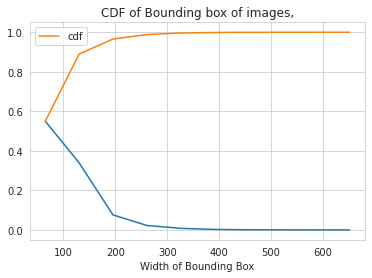

In [59]:
counts,bin_edges=np.histogram(bbox_width,bins=10,density=True)
pdf = counts/sum(counts)
cdf=np.cumsum(pdf)
plot,=plt.plot(bin_edges[1:],pdf)
plot1,=plt.plot(bin_edges[1:],cdf)
plt.xlabel('Width of Bounding Box')
plt.title("CDF of Bounding box of images,")
plt.legend([plot1],['cdf'])
plt.show()

Observations:
1. Most of the bounding boxes are having width between 50 and 200.
2. Around 90 percent of images has width of bounding box less than 180.
3. Average width of bounding boxes is aprrox. 80

In [ ]:
#bbox height distibution 
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
sns.distplot(bbox_height)
plt.title("Height of bbox ")
plt.ylabel("Density")
plt.show()

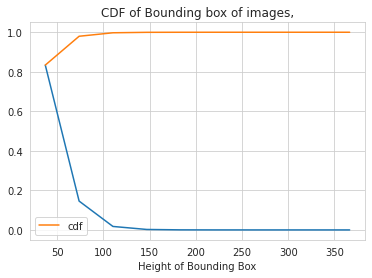

In [60]:
counts,bin_edges=np.histogram(bbox_height,bins=10,density=True)
pdf = counts/sum(counts)
cdf=np.cumsum(pdf)
plot,=plt.plot(bin_edges[1:],pdf)
plot1,=plt.plot(bin_edges[1:],cdf)
plt.xlabel('Height of Bounding Box')
plt.title("CDF of Bounding box of images,")
plt.legend([plot1],['cdf'])
plt.show()

Observations:
1. Most of the bounding boxes are having heigth between 20 and 50.
2. There are few  bounding boxes whose height is greater than 50.
3. Average width of bounding boxes is aprrox. 30

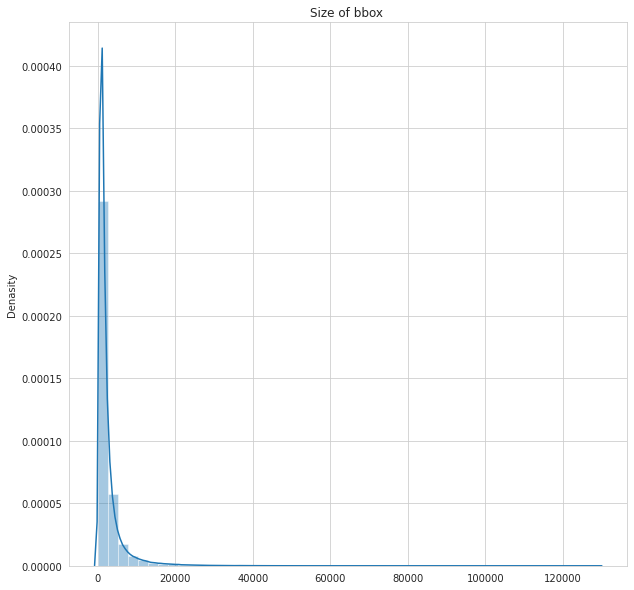

In [61]:
#bbox size distibution
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
sns.distplot(bbox_size)
plt.title("Size of bbox ")
plt.ylabel("Denasity")
plt.show()

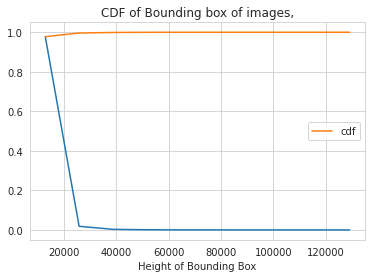

In [62]:
counts,bin_edges=np.histogram(bbox_size,bins=10,density=True)
pdf = counts/sum(counts)
cdf=np.cumsum(pdf)
plot,=plt.plot(bin_edges[1:],pdf)
plot1,=plt.plot(bin_edges[1:],cdf)
plt.xlabel('Height of Bounding Box')
plt.title("CDF of Bounding box of images,")
plt.legend([plot1],['cdf'])
plt.show()

Observations:
1. Most of the bounding boxes are having  area less than 20000.
2. There are few  bounding boxes whose area is greater than 20000.
3. Average area of bounding boxes is aprrox. 5000

# EDA on ICDAR 15 dataset

In [11]:
!unzip "/content/ch4_training_images.zip" -d "icadar_1000/"
!unzip "/content/ch4_training_localization_transcription_gt.zip" -d "/content/icadar_gt/"

Archive:  /content/ch4_training_images.zip
replace icadar_1000/img_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/ch4_training_localization_transcription_gt.zip
  inflating: /content/icadar_gt/gt_img_1.txt  
  inflating: /content/icadar_gt/gt_img_2.txt  
  inflating: /content/icadar_gt/gt_img_3.txt  
  inflating: /content/icadar_gt/gt_img_4.txt  
  inflating: /content/icadar_gt/gt_img_5.txt  
  inflating: /content/icadar_gt/gt_img_6.txt  
  inflating: /content/icadar_gt/gt_img_7.txt  
  inflating: /content/icadar_gt/gt_img_8.txt  
  inflating: /content/icadar_gt/gt_img_9.txt  
  inflating: /content/icadar_gt/gt_img_10.txt  
  inflating: /content/icadar_gt/gt_img_11.txt  
  inflating: /content/icadar_gt/gt_img_12.txt  
  inflating: /content/icadar_gt/gt_img_13.txt  
  inflating: /content/icadar_gt/gt_img_14.txt  
  inflating: /content/icadar_gt/gt_img_15.txt  
  inflating: /content/icadar_gt/gt_img_16.txt  
  inflating: /content/icadar_gt/gt_img_17.txt  
  inflating: /c

In [4]:
#Getting all directories of whole images of icdar 15 dataset in a list
total_images=image_describe('icadar_1000')
print(len(total_images))

1it [00:00, 258.22it/s]

1000


In [12]:
#Getting path of whole ground_truth of icdar 15 dataset in a list
total_gt=image_describe('icadar_gt')
print(len(total_gt))

1it [00:00, 278.86it/s]

1000


In [13]:
value=[sorted(total_images),sorted(total_gt)]
icdar15 = pd.DataFrame(value, index=['imname', 'ground_truth']).T
icdar15.head()

imname               ground_truth
0     icadar_1000/img_1.jpg     icadar_gt/gt_img_1.txt
1    icadar_1000/img_10.jpg    icadar_gt/gt_img_10.txt
2   icadar_1000/img_100.jpg   icadar_gt/gt_img_100.txt
3  icadar_1000/img_1000.jpg  icadar_gt/gt_img_1000.txt
4   icadar_1000/img_101.jpg   icadar_gt/gt_img_101.txt

# Visualizing icdar15 images

In [24]:
#plotting some  images
img_list=icdar15['imname'].values
show_images(img_list[:4])

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [7]:
#Getting width , height and size in bytes of images
from tqdm import tqdm
width=[]
height=[]
size=[]
for img in tqdm(total_images):
    image = cv2.imread(img,cv2.COLOR_BGR2RGB)
    size.append(int(os.path.getsize(img)/1024))
    wid, heig,_=image.shape
    width.append(wid)
    height.append(heig)
    

100%|██████████| 1000/1000 [00:12<00:00, 82.59it/s]


In [8]:
#Converting image data to csv file
lst=[width,height,size]
icdar_data = pd.DataFrame(lst, index=['width', 'height','size']).T

In [ ]:
icdar_data.shape

(1000, 3)

In [ ]:
icdar_data.describe()

width  height         size
count  1000.0  1000.0  1000.000000
mean    720.0  1280.0    88.427000
std       0.0     0.0    19.843246
min     720.0  1280.0    22.000000
25%     720.0  1280.0    76.750000
50%     720.0  1280.0    86.000000
75%     720.0  1280.0   100.000000
max     720.0  1280.0   187.000000

This icdar dataset  has all images having width as 720 and height as 1280.Also these are the real world images which are having some blury background and not much clear as compared to synthText data set.

In [28]:
# Plot a single image
from matplotlib import pyplot as plt
plt.figure(figsize=(16, 16))
image = cv2.imread('icadar_1000/img_1.jpg', cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

We can see through these images that the images are large but pretty blur and the texts are smaller as compared to the background. Text in these images are harder to detect and recognize.

ref - https://rrc.cvc.uab.es/?ch=4&com=tasks

Here is the format of the ground truth labels x1, y1, x2, y2, x3, y3, x4, y4, transcription

It contains the (x, y) coordinates of rectangle in clockwise manner starting from top left corner followed by corresponding text transcription (actual word in text).

The text transcription also contains "###", which means "Don't care" word. For now, we will ignore such words

In [31]:
# Extract ground truth bounding boxes
icdar15['ground_bboxes'] = icdar15['ground_truth'].map(extract_gt)

# Extract text for each ground truth
icdar15['ground_txt'] = icdar15['ground_truth'].map(extract_txt)
icdar15.head()

imname  ...                                         ground_txt
0     icadar_1000/img_1.jpg  ...  [Genaxis Theatre, [06], ###, 62-03, Carpark, #...
1    icadar_1000/img_10.jpg  ...  [###, HarbourFront, CC22, bua, ###, ###, ###, ...
2   icadar_1000/img_100.jpg  ...     [Way, out, ###, Line, Platform, ###, ###, ###]
3  icadar_1000/img_1000.jpg  ...                               [###, ###, ###, ###]
4   icadar_1000/img_101.jpg  ...  [CARE, STICKER, FOR, ###, MORE, ###, ###, ###,...

[5 rows x 4 columns]

# Visualizig images with bounding boxes

In [32]:
imname=icdar15['imname'].values
gt_bb=icdar15['ground_bboxes'].values
titles=icdar15['ground_txt'].values
plot_bb_icdar(imname[:4],gt_bb[:4],titles[:4])

In [34]:
bbox=[x.shape[0] for x in icdar15['ground_bboxes']]

In [35]:
#bbox distibution
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
sns.distplot(bbox)
plt.title("Number of bbox per image ")
plt.ylabel("Density")
plt.show()

In [45]:
counts,bin_edges=np.histogram(bbox,bins=10,density=True)
pdf = counts/sum(counts)
cdf=np.cumsum(pdf)
plot,=plt.plot(bin_edges[1:],pdf)
plot1,=plt.plot(bin_edges[1:],cdf)
plt.xlabel('Number of Bounding Box')
plt.title("CDF of Bounding box of images,")
plt.legend([plot1],['cdf'])
plt.show()

1. Most to the bounding box  per image are between 1 to 25.
2. Around 90 percent of bonding boxes are below 30.
3. Average number of bounding boxes per image is aprrox. 8.

In [38]:
bbox_width, bbox_height, bbox_size = [], [], []

for index in tqdm(range(len(icdar15['ground_bboxes']))):
    for bbox_index in range(icdar15['ground_bboxes'][index].shape[0]):
        top_left = (icdar15['ground_bboxes'][index][bbox_index][0], icdar15['ground_bboxes'][index][bbox_index][1])
        top_right = (icdar15['ground_bboxes'][index][bbox_index][2], icdar15['ground_bboxes'][index][bbox_index][3])
        bottom_left = (icdar15['ground_bboxes'][index][bbox_index][6], icdar15['ground_bboxes'][index][bbox_index][7])

        top_left = tuple(map(int, top_left))
        top_right = tuple(map(int, top_right))
        bottom_left = tuple(map(int, bottom_left))

        width = distance_Meaure(top_left, top_right)
        height = distance_Measure(top_left, bottom_left)
        
        bbox_width.append(width)
        bbox_height.append(height)
        bbox_size.append(width*height)

100%|██████████| 1000/1000 [00:00<00:00, 1092.14it/s]


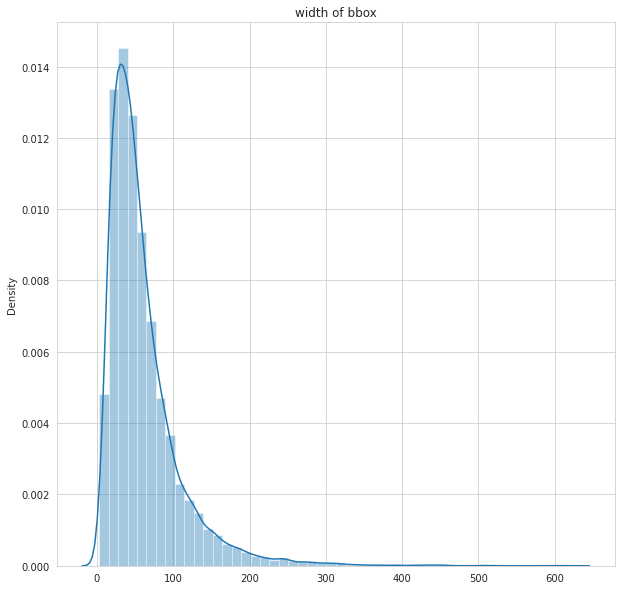

In [39]:
#bbox width distibution
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
sns.distplot(bbox_width)
plt.title("width of bbox")
plt.ylabel("Density")
plt.show()

In [46]:
counts,bin_edges=np.histogram(bbox_width,bins=10,density=True)
pdf = counts/sum(counts)
cdf=np.cumsum(pdf)
plot,=plt.plot(bin_edges[1:],pdf)
plot1,=plt.plot(bin_edges[1:],cdf)
plt.xlabel('Width of Bounding Box')
plt.title("CDF of Bounding box of images,")
plt.legend([plot1],['cdf'])
plt.show()

1. Most to the bounding box are having width betweeen 30 to 100.
2. Around 95 percent of bonding boxes are below 150.
3. Average width of all images is approx. 60

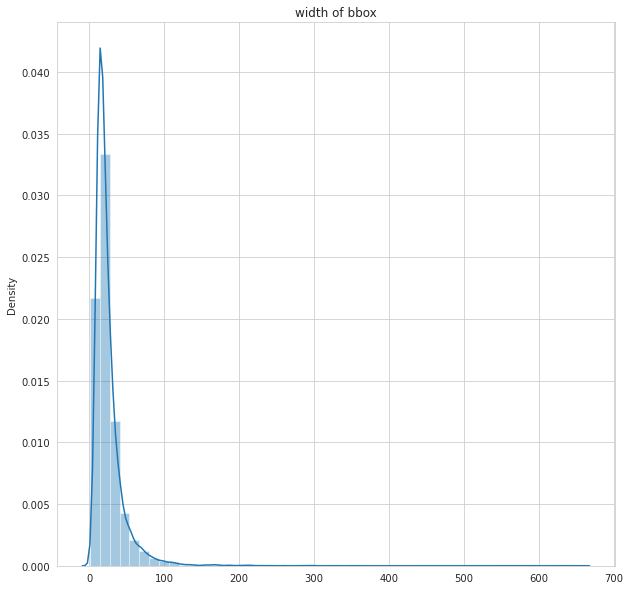

In [ ]:
#bbox width distibution
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
sns.distplot(bbox_height)
plt.title("width of bbox")
plt.ylabel("Density")
plt.show()

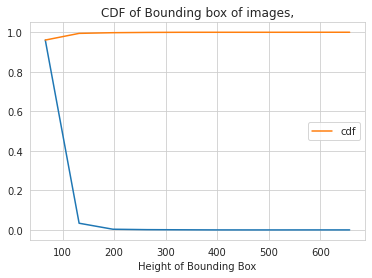

In [42]:
counts,bin_edges=np.histogram(bbox_height,bins=10,density=True)
pdf = counts/sum(counts)
cdf=np.cumsum(pdf)
plot,=plt.plot(bin_edges[1:],pdf)
plot1,=plt.plot(bin_edges[1:],cdf)
plt.xlabel('Height of Bounding Box')
plt.title("CDF of Bounding box of images,")
plt.legend([plot1],['cdf'])
plt.show()

1. Most to the bounding box  are having height betweeen 10 to 60.
2. few are having width more than 60.

3. Average height of all bounding boxes is approx. 40

4. Most of the bounding boxes have height have almost same height.

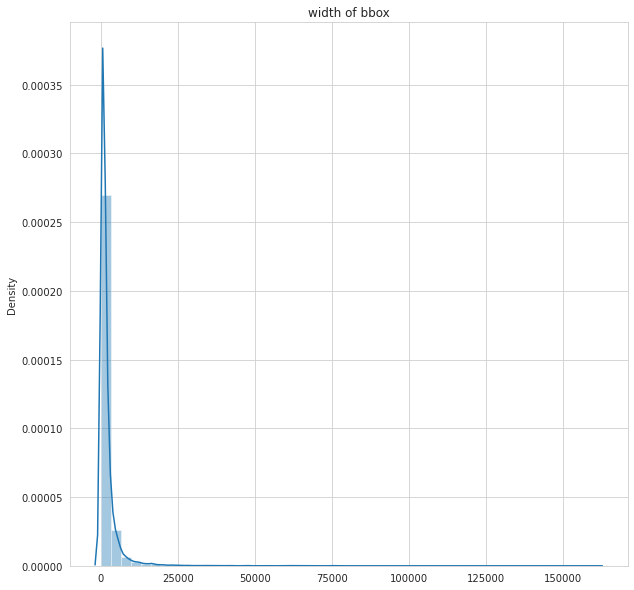

In [ ]:
#bbox width distibution
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
sns.distplot(bbox_size)
plt.title("width of bbox")
plt.ylabel("Density")
plt.show()

In [47]:
counts,bin_edges=np.histogram(bbox_size,bins=10,density=True)
pdf = counts/sum(counts)
cdf=np.cumsum(pdf)
plot,=plt.plot(bin_edges[1:],pdf)
plot1,=plt.plot(bin_edges[1:],cdf)
plt.xlabel('Size of Bounding Box')
plt.title("CDF of Bounding box of images,")
plt.legend([plot1],['cdf'])
plt.show()

1. Most to the bounding box  are having size as 5000.
2. Few are having width more than 15000.
3. Almost all bounding boxes are having the same size.